# Notebook 3 : Maintenance

Dans ce notebook, on va essayer d'estimer la période de temps à partir de laquelle une maintenance de notre modélisation précédente devra être effectuée.

### Procédure à employer

Pour cela, on va devoir calculer un score ARI (Adjusted Rand Index).

Ce score sert à comparer deux clusterings. Voici donc comment on va procéder :

##### étape 1

- En premier lieu, je vais me placer à une certaine date que je vais choisir arbitrairement. Ce sera un an après le début des commandes, afin d'avoir à t0 (le temps initial), suffisamment de données. (un premier dataframe, df_0)

- Ce jeu de données sera scalé, avec un scaler qui sera fit sur lui (scaler0), et on aura donc un nouveau jeu de données (df0_sc0).

- Ensuite, sur ce jeu de donées, je vais entraîner un algorithme de clustering conforme au notebook précédent (K-Means, 5 clusters), on l'appellera km0.

- A partir de là, on a notre modélisation au temps t0. Pour la comparer avec des modélisations futures, on doit avancer dans le temps.

##### étape 2

- On va se placer à un deuxième temps t1, par exemple t0 + 1 semaine. De la même manière, on créé un dataframe avec toutes les commandes passées avant t1. (df_1) 

- De ce dataframe, on va en tirer deux. En effet, on va créer df1_sc0 (df_1 scalé par scaler0), qui sera notre dataframe utilisé ensuite par km0. On va également créer un scaler1, entraîné, lui, sur df_1 (et non pas sur df_0). Et on l'utilisera directement sur df_1, créant ainsi df1_sc1.

- Sur df1_sc0, on demandera à km0 de prédire les clusters (pas de s'entraîner, mais bien de prédire les clusters). Tandis que sur df1_sc1, on entraînera km1 et on en récupèrera les labels.

##### étape 3

- Cette dernière sous-étape nous permet donc d'obtenir deux versions différentes d'un clustering sur le même temps donné : une version "à partir de la simulation initiale", et une version "comme si on venait de faire la maintenance". C'est sur ces deux versions qu'on calcule le score ARI.

##### étape 4

- On itère le processus en avançant encore d'une semaine (t2, t3, t4, ...) et on continue jusqu'à ce que le score ARI descende en dessous de 0.8, c'est le seuil qu'on se fixe à partir duquel il faudra effectivement faire la maintenance.





...

C'est parti

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn import metrics
import math

In [2]:
whole_df = pd.read_csv("4_features.csv")

In [3]:
whole_df

,recency(days),frequency,monetary,review_score,cluster
0,519.0,1.0,146.870,4.0,0
1,278.0,1.0,335.480,5.0,1
2,151.0,1.0,157.730,5.0,1
3,218.0,1.0,173.300,5.0,1
4,80.0,1.0,252.250,5.0,1
...,...,...,...,...,...
95374,174.0,2.0,111.430,4.5,3
95375,171.0,2.0,186.800,2.0,3
95376,271.0,2.0,59.305,4.0,3
95377,318.0,2.0,142.615,1.0,3


Bien, on a les 4 colonnes qu'on veut. Il faut maintenant le fixer dans le temps.

## Etape 1

In [4]:
#Je place t0 à un an après la première commande.
t_0 = whole_df["recency(days)"].max() - 365 #On se place à la récence maximale (la commande la plus vieille) et on s'autorise 365 jours de commande

#Je créé df0
df_0 = whole_df.loc[whole_df["recency(days)"] >= t_0 , :]

#J'adapte la récence à la temporalité
df_0.loc[:,"recency(days)"] -= t_0

df_0.describe()

C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\2954757584.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0.loc[:,"recency(days)"] -= t_0


,recency(days),frequency,monetary,review_score,cluster
count,22384.000000,22384.000000,22384.000000,22384.000000,22384.000000
mean,100.984721,1.026492,161.406540,4.125630,0.422043
std,69.124977,0.174976,232.607765,1.301995,0.963757
min,0.000000,1.000000,2.570000,1.000000,0.000000
25%,43.000000,1.000000,60.850000,4.000000,0.000000
50%,94.000000,1.000000,102.580000,5.000000,0.000000
75%,152.000000,1.000000,174.040000,5.000000,0.000000
max,365.000000,6.000000,6929.310000,5.000000,4.000000


In [5]:
#Je créé mon scaler0
scaler0 = StandardScaler()
X_0 = df_0.values
scaler0.fit(X_0)

#Ainsi que df0_sc0
df0_sc0 = scaler0.transform(X_0)

#J'entraîne un K-Means
km0 = cluster.KMeans(n_clusters = 5)
km0.fit(df0_sc0)


KMeans(n_clusters=5)

## Etape 2

In [6]:
#On se place temporellement
t_1 = t_0 - 7
df_1 = whole_df.loc[whole_df["recency(days)"] >= t_1 , :]
df_1["recency(days)"] = df_1["recency(days)"] - t_1

#On créé le scaler
scaler1 = StandardScaler()
X_1 = df_1.values
scaler1.fit(X_1)

#On créé df1_sc0 et df1_sc1
df1_sc0 = scaler0.transform(X_1)
df1_sc1 = scaler1.transform(X_1)

#On récupère les labels d'un côté et le nouveau kmeans de l'autre
km1 = cluster.KMeans(n_clusters = 5)
km1.fit(df1_sc1)
real_clusters = km1.labels_
predicted_clusters = km0.predict(df1_sc0)

#On calcule le score ARI (ce que j'ai appelé "étape 3" précédemment)
ARI_1 = metrics.adjusted_rand_score(real_clusters , predicted_clusters)
ARI_1

C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\973684258.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["recency(days)"] = df_1["recency(days)"] - t_1


0.9537044577234071

## Etape 4 

(La 3ème est en fait à la fin du dernier paragraphe)

In [7]:
#En fait, il s'agit simplement de l'étape 2, mais sous forme de boucle. On doit juste stocker le ARI dans une liste.
ARI_list = []

for k in range(1, 53):
    #On se place dans la bonne temporalité
    t_k = t_0 - 7 * k
    df_k = whole_df.loc[whole_df["recency(days)"] >= t_k , :]
    df_k["recency(days)"] = df_k["recency(days)"] - t_k
    
    #On créé le bon scaler
    scaler_k = StandardScaler()
    X_k = df_k.values
    scaler_k.fit(X_k)
    
    #On créé dfk_sc0 et dfk_sck
    dfk_sc0 = scaler0.transform(X_k)
    dfk_sck = scaler_k.transform(X_k)
    
    #On récupère les labels d'un côté et le nouveau kmeans de l'autre
    km_k = cluster.KMeans(n_clusters = 5)
    km_k.fit(dfk_sck)
    real_clusters = km_k.labels_
    predicted_clusters = km0.predict(dfk_sc0)
    
    #On calcule le score ARI et on l'ajoute à la liste
    ARI_k = metrics.adjusted_rand_score(real_clusters , predicted_clusters)
    ARI_list.append(ARI_k)
    

C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\1806538131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\1806538131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\1806538131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\1806538131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\1806538131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\1806538131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\1806538131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\1806538131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\1806538131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

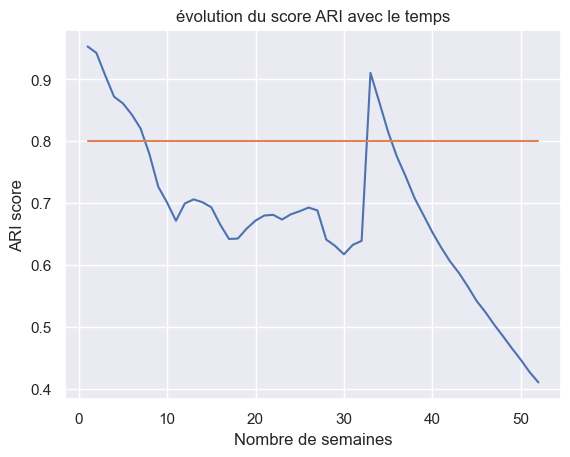

In [8]:
sns.set_theme()
plt.plot(np.linspace(1,52, num = 52),ARI_list)
plt.plot(np.linspace(1,52, num = 52),0.8*np.ones(52))
plt.title("évolution du score ARI avec le temps")
plt.xlabel("Nombre de semaines")
plt.ylabel("ARI score")
plt.show()

On observe plusieurs chose :

- Tout d'abord, on se fixe un seuil sous lequel on ne doit pas descendre : 0.8 

- On observe qu'on descend sous ce seuil après 8 semaines, qu'on repasse au-dessus après 32 semaines, et de nouveau en-dessous après 35 semaines.

- En revanche, la partie située entre 30 et 40 semaines semble être une anomalie lorsqu'on observe la tendance globale. C'est pourquoi, si je devais conclure en regardant uniquement ce graphique, je préconiserais une maintenance après 8 semaines.

- Toutefois, nous disposons en vérité de plus de 750 jours de données, et je n'ai utilisé que t0 = 365 ici. Je vais essayer d'obtenir des résultats plus stables en choisissant un t0 plus important.






Je vais légèrement modifier le code précédent pour en faire une fonction et pouvoir tester avec n'importe quel nombre de semaines.

In [9]:
def test_n_weeks(t_0):
    ARI_list = []
    t_0 = whole_df["recency(days)"].max() - t_0
    
    #Calcul du nombre maximal de semaines à afficher à la fin
    n = math.floor(t_0 / 7)
    
    #Je créé df0
    df_0 = whole_df.loc[whole_df["recency(days)"] >= t_0 , :]
    #J'adapte la récence à la temporalité
    df_0["recency(days)"] = df_0["recency(days)"] - t_0
    
    #Je créé mon scaler0
    scaler0 = StandardScaler()
    X_0 = df_0.values
    scaler0.fit(X_0)

    #Ainsi que df0_sc0
    df0_sc0 = scaler0.transform(X_0)

    #J'entraîne un K-Means
    km0 = cluster.KMeans(n_clusters = 5)
    km0.fit(df0_sc0)

    for k in range(1, n+1):
        #On se place dans la bonne temporalité
        t_k = t_0 - 7 * k
        df_k = whole_df.loc[whole_df["recency(days)"] >= t_k , :]
        df_k["recency(days)"] = df_k["recency(days)"] - t_k
        
        #On créé le bon scaler
        scaler_k = StandardScaler()
        X_k = df_k.values
        scaler_k.fit(X_k)
    
        #On créé dfk_sc0 et dfk_sck
        dfk_sc0 = scaler0.transform(X_k)
        dfk_sck = scaler_k.transform(X_k)
    
        #On récupère les labels d'un côté et le nouveau kmeans de l'autre
        km_k = cluster.KMeans(n_clusters = 5)
        km_k.fit(dfk_sck)
        real_clusters = km_k.labels_
        predicted_clusters = km0.predict(dfk_sc0)
    
        #On calcule le score ARI et on l'ajoute à la liste
        ARI_k = metrics.adjusted_rand_score(real_clusters , predicted_clusters)
        ARI_list.append(ARI_k)
        
    sns.set_theme()
    plt.plot(np.linspace(1,n, num = n),ARI_list)
    plt.plot(np.linspace(1,n, num = n),0.8*np.ones(n))
    plt.title("évolution du score ARI avec le temps")
    plt.xlabel("Nombre de semaines")
    plt.ylabel("ARI score")
    plt.show()

Cette fonction me permet, par exemple, de choisir un t0 différent. 

En effet, j'ai arbitrairement choisi t0 = 1an.

Commençons donc par t0 = 1 an et demi (donc 365 + 183 (arrondi) = 548 jours).


In [10]:
t_0 = 548

C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0["recency(days)"] = df_0["recency(days)"] - t_0
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

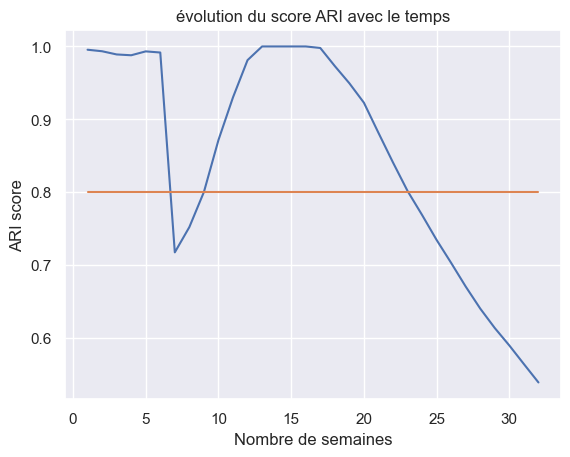

In [11]:
#On n'a que 32 semaines devant nous. Est-ce grave ? Non, on sera en-dessous de 0.8 bien avant, normalement.
test_n_weeks(t_0)

Cette fois-ci, on a plutôt l'impression d'observer une "anomalie" entre 7 et 12 semaines. (D'ailleurs, si on y réfléchit, c'est en fait la même anomalie dans nos données que la première fois. J'ai ajouté 26 semaines par rapport à la première fois, et cela correspond exactement à l'anomalie du premier graphique si on ajoute ces 26 semaines).

En dehors de cela, on observe une grande stabilité jusqu'environ 17 semaines, puis une diminution régulière.

...

Mais on a encore de la marge ! Essayons avec t0 à 610 jours, pour passer "derrière l'anomalie"

In [12]:
t_0 = 610

C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0["recency(days)"] = df_0["recency(days)"] - t_0
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k["recency(days)"] = df_k["recency(days)"] - t_k
C:\Users\Yann\AppData\Local\Temp\ipykernel_20212\822563681.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

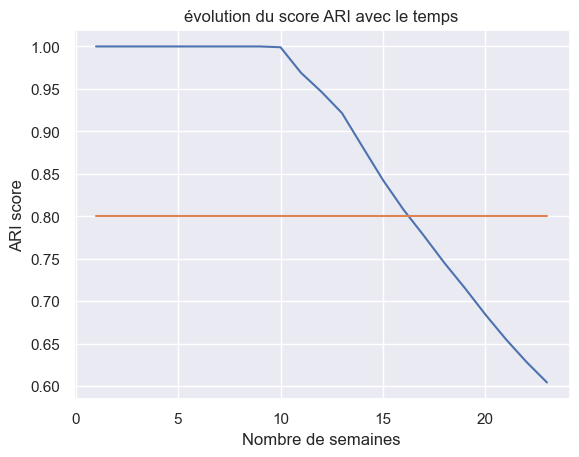

In [13]:
test_n_weeks(t_0)

# Conclusion

Avec une plage de données plus importante, on obtient une courbe plus stable.

En réalité, on n'a pas tant progressé que ça, on a simplement "zoomé" sur la partie droite du graphique précédent, en cachant un peu sous le tapis ce que j'ai appelé "anomalie" précédemment.

Toutefois, je vais tout de même utiliser ce dernier graphique pour conclure sur la maintenance, car c'est lui qui est le plus proche de la réalité (t0 = 610 jours) de ma simulation actuelle, qui a été établie sur plus de 2 ans.

Ma conclusion est donc qu'une maintenance sera nécessaire autour de 16 semaines (ou 4 mois).